In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

In [ ]:
SOURCE_PATH = "/content/drive/My Drive/COVID-19_Project/Dataset_Processing/Dataset/"

In [ ]:
TARGET_PATH = "/content/drive/My Drive/COVID-19_Project/Dataset_Processing/Masked_Dataset"

In [ ]:
source_folders = os.listdir(SOURCE_PATH)

In [ ]:
source_folders

['Normal', 'Pneumonia', 'Covid-19']

In [ ]:
target_folders = []
for i in range(len(source_folders)):
  target_folders.append(source_folders[i])
  folder = os.path.join(TARGET_PATH,source_folders[i])
  if not os.path.exists(folder):
    os.mkdir(folder)
    print(source_folders[i]," folder created")

Normal  folder created
Pneumonia  folder created
Covid-19  folder created


In [ ]:
target_folders

['Normal', 'Pneumonia', 'Covid-19']

In [ ]:
mask_generator_path = "/content/drive/My Drive/COVID-19_Project/Dataset_Processing/mask_generator_1.h5"

another masking model named "model_X_ray_lung_mask.h5" is also uploaded which was trained on the simple supervised learning process on the PC, the training and masking python script and dataset will be used and upladed later.

In [ ]:
import tensorflow as tf
mask_generator = tf.keras.models.load_model(mask_generator_path, compile=False)

In [ ]:
mask_generator.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 64, 64, 128)  131584      sequential_2[0][0]               
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 32, 32, 256)  525312      sequential_3[0][0]               
_______________________________________________________________________________________

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import cv2
import sys

In [ ]:
for i in range(len(source_folders)):
  path_source_folder = os.path.join(SOURCE_PATH, source_folders[i])
  path_destination_folder = os.path.join(TARGET_PATH, target_folders[i])
  print("Masking ", source_folders[i]," folder images !!!")
  ids_path = next(os.walk(path_source_folder))[2]
  for j in range(len(ids_path)):
    try:

      # reading, resizing the image 
      image_path = os.path.join(path_source_folder,ids_path[j])
      image = imread(image_path)
      image = resize(image, (256, 256), mode='constant', preserve_range=True)
    
      # converting to rgb format
      image_rgb = np.stack((image*0.33*0.01,image*0.33*0.01, image*0.33*0.01), axis=2)
      image_for_model = np.expand_dims(image_rgb, axis = 0)
    
      # generating the mask
      prediction = mask_generator(image_for_model, training=True)
      mask = prediction[0]
    
      # changing the datatype of mask from tensor<float32>  to np<float32>
      mask = np.float32(mask)
    
      # converting RGB mask to greyscale
      mask = 0.33*mask[:,:,0]+0.33*mask[:,:,1]+0.34*mask[:,:,2]
    
      # converting mask to binary format in dtype uint8 from float32
      mask = -(mask - 255)/255
      mask = np.uint8(mask)
      mask = np.logical_not(mask)
      mask = np.uint8(mask)

      # converting image to uint8 dtype for masking
      # multiply by 2^8 = 256 for uint 8 conversion from float64 format
      image_seg = image_rgb*256
      image_seg = np.uint8(image_seg)

      # preparing for masking the image
      rows, cols, channels = image_seg.shape
      image_seg = image_seg[0:rows, 0:cols]

      # segmenting the image
      segmented_image = cv2.bitwise_and(image_seg, image_seg, mask = mask)

      # saving the segmented image in the destination folder
      print("Saving image ", source_folders[i],"_", j)
      cv2.imwrite(path_destination_folder+"/{}_".format(source_folders[i])+"{}.png".format(j),segmented_image)

    except:
      print()
      print("Oops!", sys.exc_info()[0], "occurred.")
      print("Image was ", source_folders[i],"_", j)
      print("Processing exception image !!!")

      # rereadin the image
      image_path = os.path.join(path_source_folder,ids_path[j])
      image = imread(image_path)

      # image enhancement of uint8 image by default

      # resizing the image and converting to grayscale
      image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST) 
      image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

      # histogram equalization
      gray_img_eqhist=cv2.equalizeHist(image_gray)

      # Applying CLAHE - Contrast Limited Adaptive Histogram Equalization
      clahe=cv2.createCLAHE(clipLimit=4)
      gray_img_clahe=clahe.apply(gray_img_eqhist)

      # applying Thresholding Technique - cv2.THRESH_TRUNC
      th=222
      max_val=255
      ret, thresh_image = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TRUNC)

      # converting back to rgb image and expanding dim for masking model
      thresh_image_rgb = np.stack((thresh_image*0.33*0.01,thresh_image*0.33*0.01, thresh_image*0.33*0.01), axis=2)
      image_for_model = np.expand_dims(thresh_image_rgb, axis = 0)

      # generating the mask for the image
      prediction = mask_generator(image_for_model, training=True)
      mask = prediction[0]

      # converting the mask to greyscale from rgb
      mask = np.float32(mask)
      mask = 0.33*mask[:,:,0]+0.33*mask[:,:,1]+0.34*mask[:,:,2]
    
      # converting mask to binary format in dtype uint8 from float32
      mask = -(mask - 255)/255
      mask = np.uint8(mask)
      mask = np.logical_not(mask)
      mask = np.uint8(mask)

      # changing the datatype of rgb image to uint8
      image_seg = thresh_image_rgb*256
      image_seg = np.uint8(image_seg)

      # preparing for masking the image
      rows, cols, channels = image_seg.shape
      image_seg = image_seg[0:rows, 0:cols]

      # segmenting the image
      segmented_image = cv2.bitwise_and(image_seg, image_seg, mask = mask)
      
      print("Saving image ", source_folders[i],"_", j)
      cv2.imwrite(path_destination_folder+"/{}_".format(source_folders[i])+"{}.png".format(j),segmented_image)

      print("Proceeding to next image ")
      print()

      continue


Streaming output truncated to the last 5000 lines.
Saving image  Normal _ 197
Saving image  Normal _ 198
Saving image  Normal _ 199
Saving image  Normal _ 200
Saving image  Normal _ 201
Saving image  Normal _ 202
Saving image  Normal _ 203
Saving image  Normal _ 204
Saving image  Normal _ 205
Saving image  Normal _ 206
Saving image  Normal _ 207
Saving image  Normal _ 208
Saving image  Normal _ 209
Saving image  Normal _ 210
Saving image  Normal _ 211
Saving image  Normal _ 212
Saving image  Normal _ 213
Saving image  Normal _ 214
Saving image  Normal _ 215
Saving image  Normal _ 216
Saving image  Normal _ 217
Saving image  Normal _ 218
Saving image  Normal _ 219
Saving image  Normal _ 220
Saving image  Normal _ 221
Saving image  Normal _ 222
Saving image  Normal _ 223
Saving image  Normal _ 224
Saving image  Normal _ 225
Saving image  Normal _ 226
Saving image  Normal _ 227
Saving image  Normal _ 228
Saving image  Normal _ 229
Saving image  Normal _ 230
Saving image  Normal _ 231
Savi

# Work on the exception Images

In [ ]:
path_source_folder = os.path.join(SOURCE_PATH, source_folders[2])

In [ ]:
ids_path = next(os.walk(path_source_folder))[2]

In [ ]:
image_path = os.path.join(path_source_folder,ids_path[341])

In [ ]:
 image = imread(image_path)

In [ ]:
image.shape

(324, 331, 3)

In [ ]:
image.dtype

dtype('uint8')

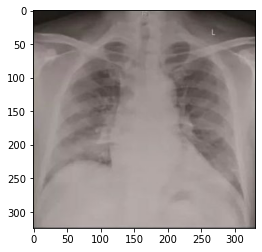

In [ ]:
plt.imshow(image)

In [ ]:
import cv2

In [ ]:
image = cv2.resize(image, (256, 256),  
               interpolation = cv2.INTER_NEAREST) 

In [ ]:
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

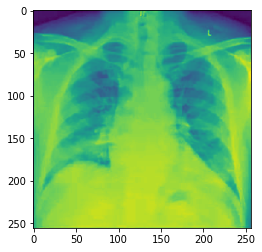

In [ ]:
plt.imshow(image_gray)

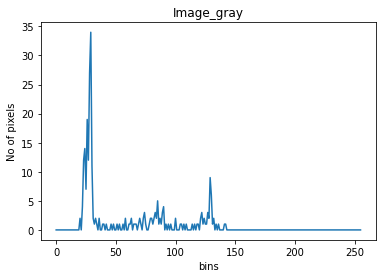

In [ ]:
hist=cv2.calcHist(image_gray,[0],None,[256],[0,256])
plt.title("Image_gray")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)

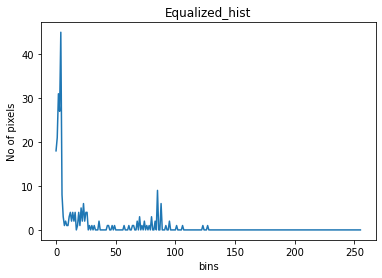

In [ ]:
gray_img_eqhist=cv2.equalizeHist(image_gray)
hist=cv2.calcHist(gray_img_eqhist,[0],None,[256],[0,256])
plt.title("Equalized_hist")
plt.xlabel('bins')
plt.ylabel("No of pixels")
plt.plot(hist)

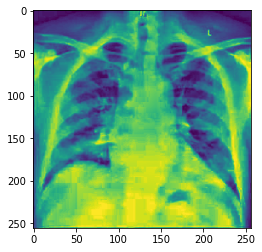

In [ ]:
clahe=cv2.createCLAHE(clipLimit=4)
gray_img_clahe=clahe.apply(gray_img_eqhist)
plt.imshow(gray_img_clahe)

In [ ]:
th=222
max_val=255
ret, o1 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY)
#cv2.putText(o1,"Thresh_Binary",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o2 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_BINARY_INV)
#cv2.putText(o2,"Thresh_Binary_inv",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o3 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TOZERO)
#cv2.putText(o3,"Thresh_Tozero",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o4 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TOZERO_INV)
#cv2.putText(o4,"Thresh_Tozero_inv",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret, o5 = cv2.threshold(gray_img_clahe, th, max_val, cv2.THRESH_TRUNC)
#cv2.putText(o5,"Thresh_trunc",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)
ret ,o6=  cv2.threshold(gray_img_clahe, th, max_val,  cv2.THRESH_OTSU)
#cv2.putText(o6,"Thresh_OSTU",(40,100),cv2.FONT_HERSHEY_SIMPLEX,2,(255,255,255),3,cv2.LINE_AA)

final=np.concatenate((o1,o2,o3),axis=1)
final1=np.concatenate((o4,o5,o6),axis=1)

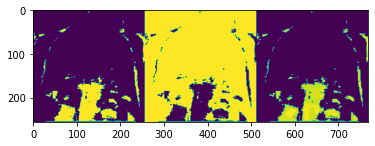

In [ ]:
plt.imshow(final)

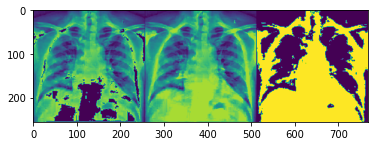

In [ ]:
plt.imshow(final1)

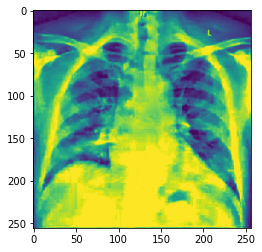

In [ ]:
plt.imshow(o5)

In [ ]:
o5_rgb = np.stack((o5*0.33*0.01,o5*0.33*0.01, o5*0.33*0.01), axis=2)

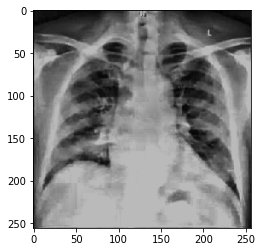

In [ ]:
plt.imshow(o5_rgb)